In [1]:
def count_parameters_conv(in_channels: int, out_channels: int, kernel_size: int, bias: bool):
    return (in_channels*kernel_size**2+(bias==True))*out_channels

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision.transforms as T
from IPython.display import clear_output
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm
from PIL import Image

In [15]:
def train(model: nn.Module):
    model.train()

    total_loss = 0

    for x,y in tqdm(train_loader, desc = 'Train'):
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        total_loss = loss.item()

        loss.backward()

        optimizer.step()
    
    total_loss /= len(train_loader)
    return total_loss

In [12]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc = 'Evaluation'):
        output = model(x)

        loss = loss_fn(output, y)
        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total+=y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct/total
    
    return total_loss, accuracy

In [13]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize = (20, 10))

    plt.title(title + ' loss')

    plt.plot(train_loss, label = 'Train Loss')
    plt.plot(valid_loss, label = 'Valid Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize = (20, 10))

    plt.title(title + ' accuracy')
    plt.plot(valid_accuracy)

    plt.grid()
    plt.show()

In [6]:
def create_mlp_model() -> nn.Module:
    my_model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )
    return my_model
    

In [7]:
mnist_train = MNIST(
    '../datasets/mnist',
    train = True,
    download = True,
    transform = T.ToTensor()
)

In [8]:
mnist_valid = MNIST(
    '../datasets/mnist',
    train = False,
    download = True,
    transform = T.ToTensor()
)

In [9]:
train_loader = DataLoader(mnist_train, batch_size = 64, shuffle = True)
valid_loader = DataLoader(mnist_valid, batch_size = 64, shuffle = False)

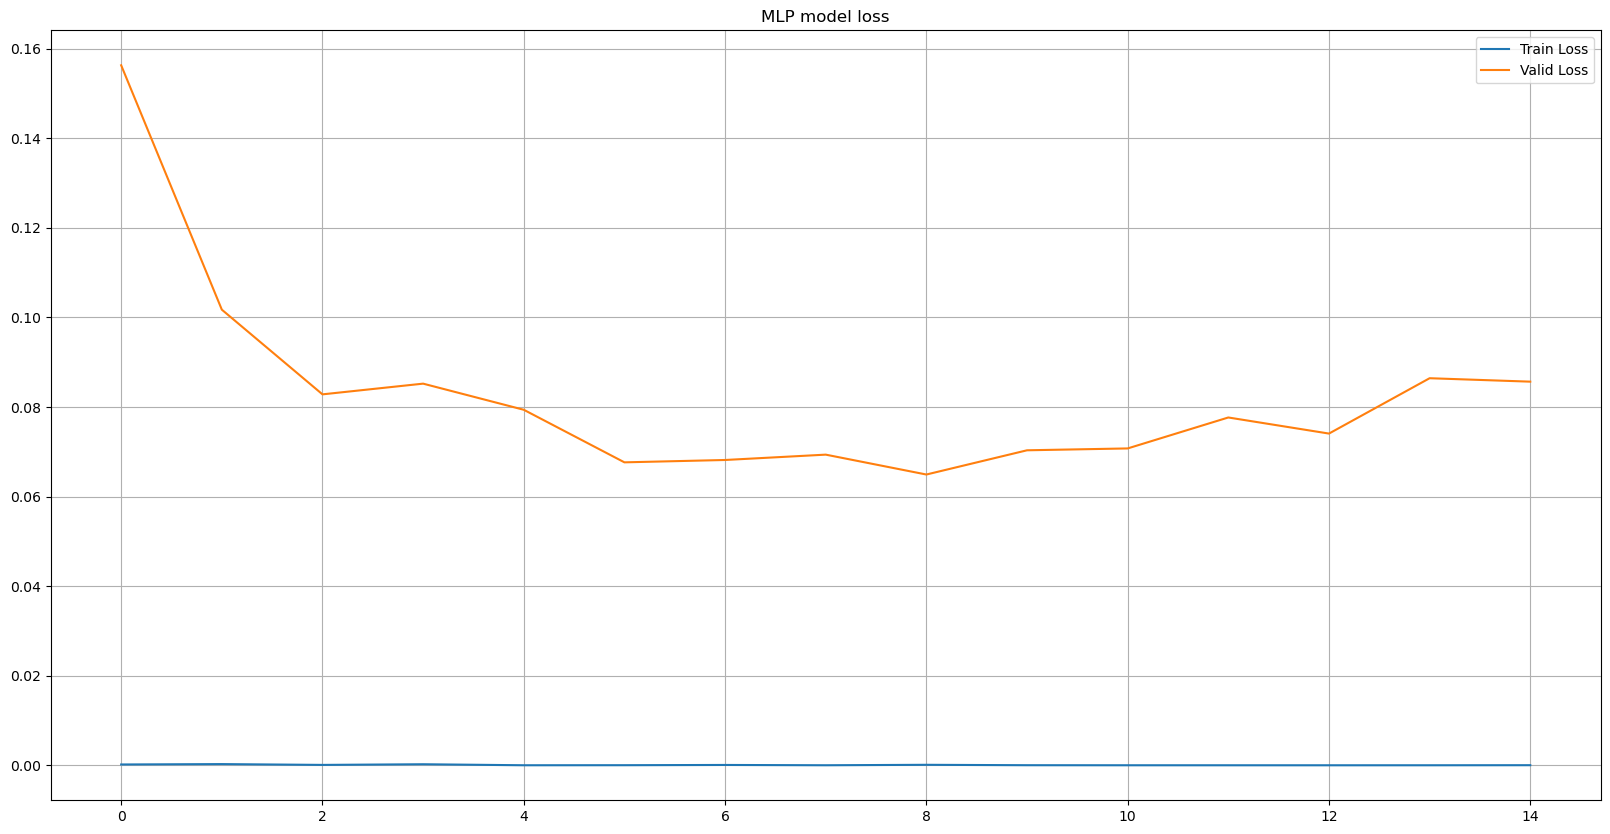

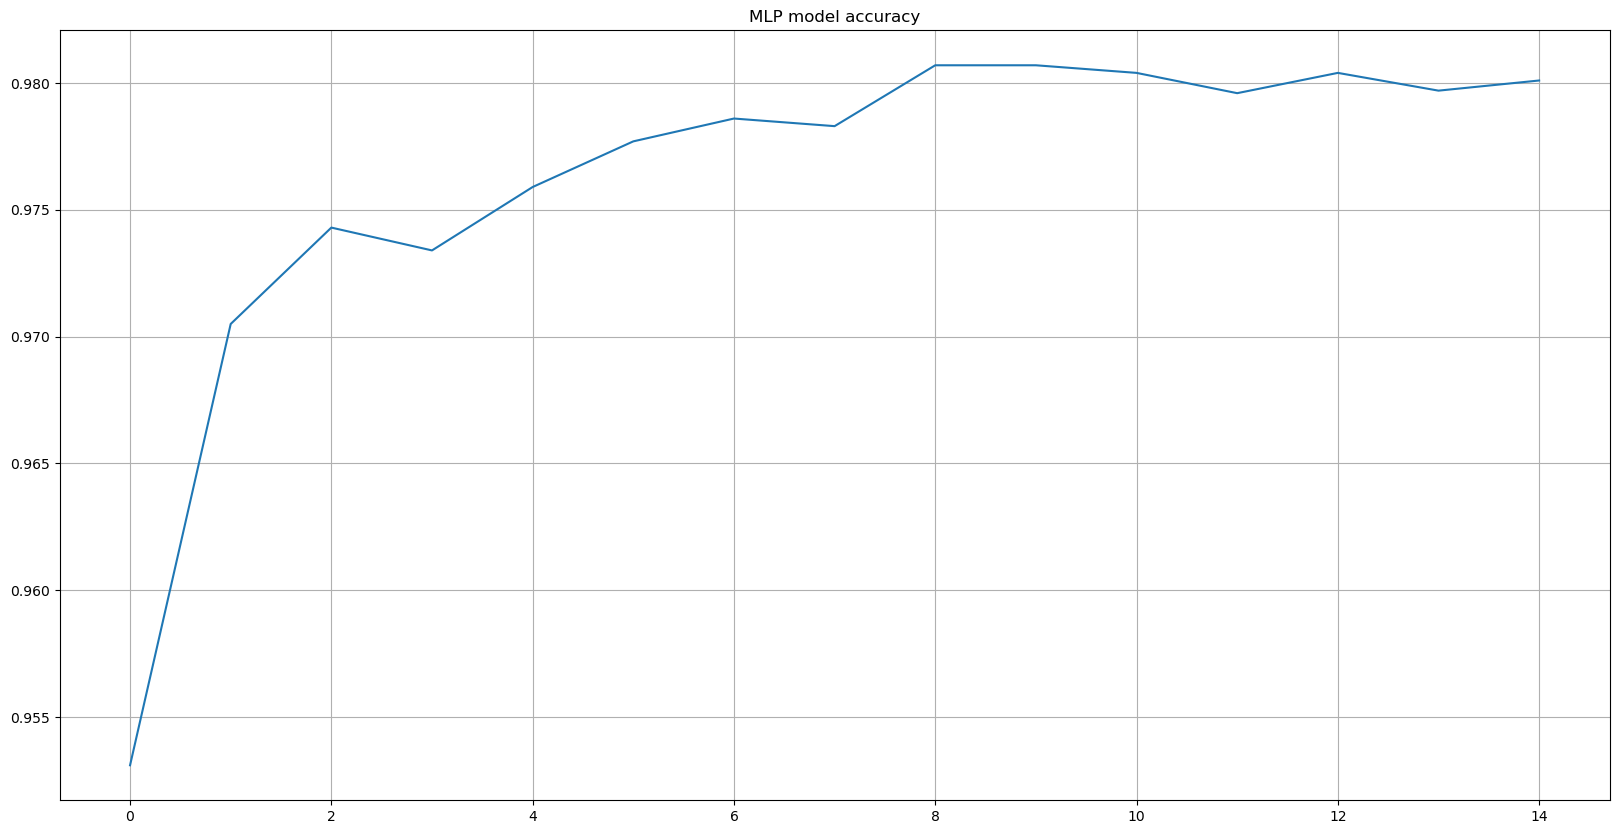

In [16]:
my_model = create_mlp_model()
num_epochs = 15
optimizer = torch.optim.Adam(my_model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()
train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

for epoch in range(num_epochs):
    train_loss = train(my_model)

    valid_loss, valid_accuracy = evaluate(my_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')
torch.save(my_model.state_dict(), 'model_weights.pt')

### Напишем сверточную нейронную сеть

In [39]:
import torch
from torch import nn
def create_conv_model():
    return nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),

        nn.Flatten(),
        nn.Linear(7 * 7 * 64, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

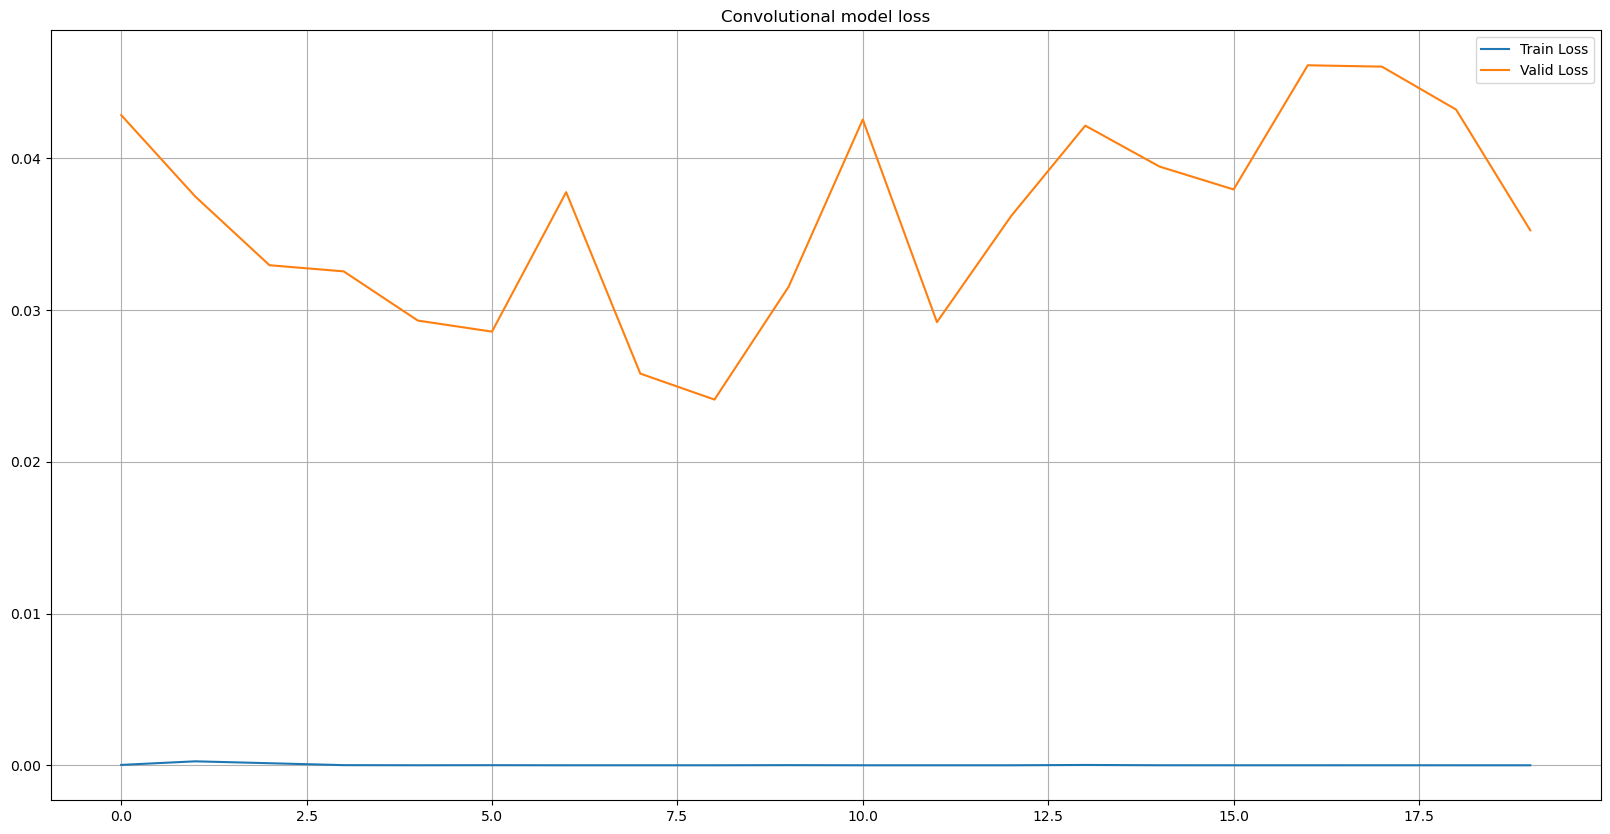

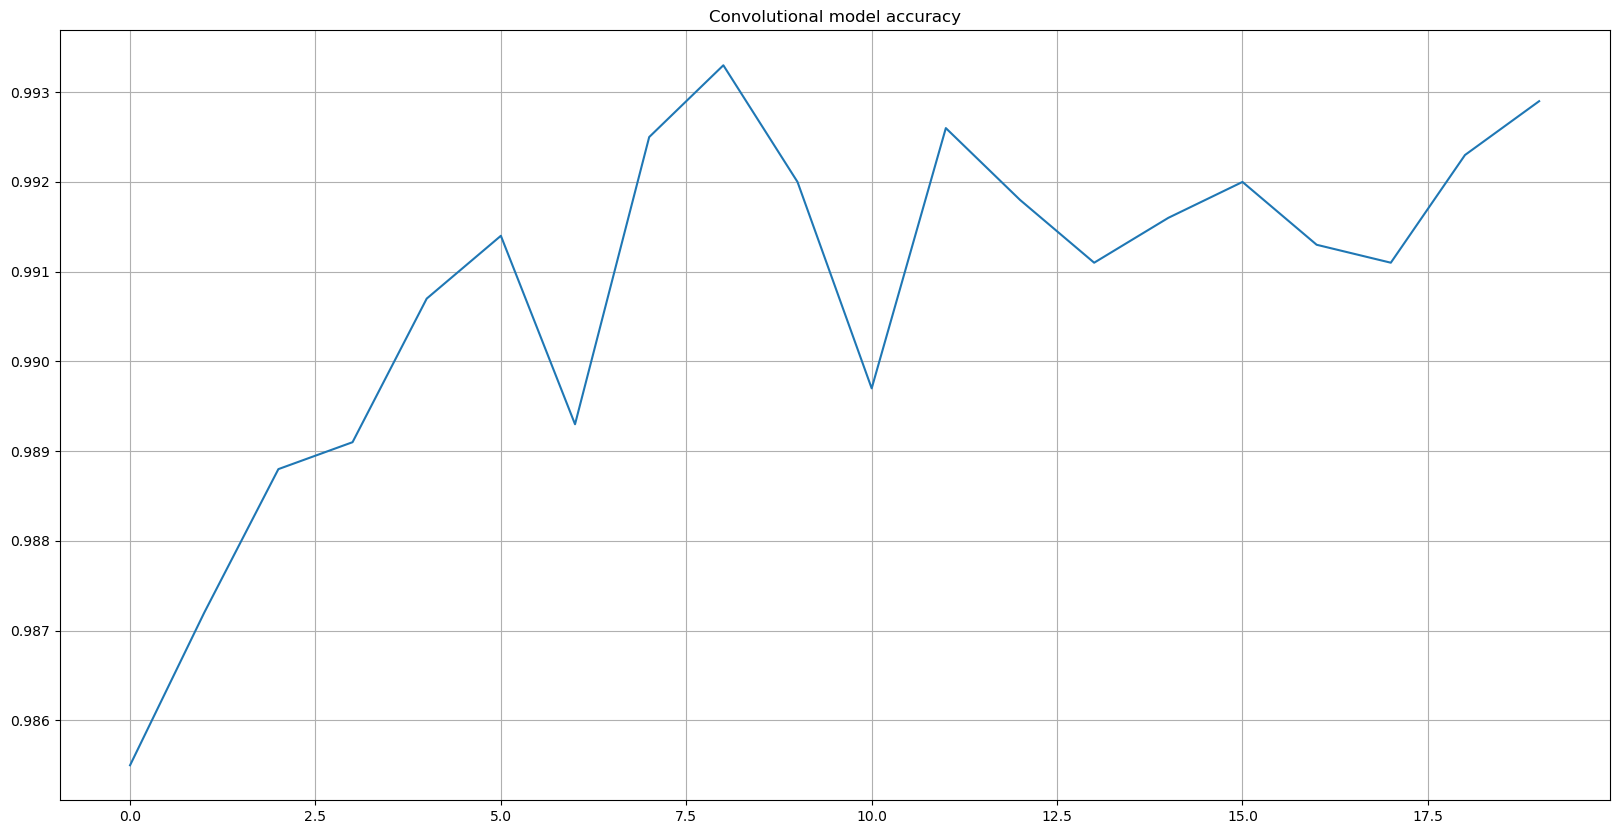

In [40]:
my_conv_model = create_conv_model()
num_epochs = 20
optimizer = torch.optim.Adam(my_conv_model.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

train_loss_history, valid_loss_history, valid_accuracy_history = [], [], []
for epoch in range(num_epochs):
    train_loss = train(my_conv_model)

    valid_loss, valid_accuracy = evaluate(my_conv_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'Convolutional model')
    torch.save(my_conv_model.state_dict(), 'my_conv_weights.pt')